# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

## Imports and wandb login

Most of the necessaries imports to run the code. 
Weights and biases installation and login

In [1]:
# Using weights and biases
!pip install wandb -qU

In [2]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import wandb
import os
import random

In [ ]:
# Login to weights and biases account
wandb.login()

## Training, evaluation and testing code

This section contains the code that implements the training, evaluation and testing pipeline that every model will use.

**Note**: to make the notebook easier to read I deleted all the printed losses and accuracies leaving only the confusion matrix of each run. The losses and accuracies will be collected in weights and biases reports.

In [4]:
from tqdm import tqdm
from sklearn.metrics import  confusion_matrix
import pandas as pd
import seaborn as sn

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dataloader, optimizer, epoch, device='cpu'):
    model.train()
    # Accumulate the losses of this epoch
    losses = []
    for (images, targets) in tqdm(dataloader, desc=f'Training epoch {epoch}', leave=True):
        images, targets = images.to(device), targets.to(device)
        # Training step for the current batch of images
        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model during training over all samples in the data loader.
def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    # Accumulate the validation losses and the number of total and correct predictions
    losses = []
    correct = 0
    total = 0
    # Since we're not training, no need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, targets = data
            images, targets = images.to(device), targets.to(device)
            # Calculate outputs and losses of this batch of images
            logits = model(images)
            loss = F.cross_entropy(logits, targets)
            losses.append(loss.item())
            # Select the class with the highest energy as the prediction
            _, predicted = torch.max(logits.data, 1)
            # Update the number of all the targets and correct predictions
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    print(f'Accuracy of the network: {100 * correct / total} %')
    return np.mean(losses),  correct / total

# Function to evaluate the best model on the test dataset, like the previous function with more in-depth informations
def test_evaluation(model, dataloader,classes, device='cpu'):
    model.eval()
    # Accumulate the number of total and correct predictions, ground truths and predictions for the confusion matrix
    correct = 0
    total = 0
    predictions_conf = []
    ground_truths_conf = []
    with torch.no_grad():
        for data in dataloader:
            images, targets = data
            # Collect the ground truths
            ground_truths_conf.extend(targets.detach().cpu().numpy())
            images, targets = images.to(device), targets.to(device)
            # Calculate outputs by running images through the network
            logits = model(images)
            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(logits.data, 1)
            # Collect the predictions
            predictions_conf.extend(predicted.detach().cpu().numpy())
            # Update the number of all the targets and correct predictions
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    print(f'Test accuracy of the network: {100 * correct / total} %')

    # Build and print confusion matrix
    cf_matrix = confusion_matrix(ground_truths_conf, predictions_conf)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    return  correct / total


### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

#### Data preparation MNIST



In [5]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
MNIST_train = MNIST(root='./data', train=True, download=True, transform=transform)
MNIST_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train set into train and validation sets.
val_size = 5000
#set seed to always have the same training/validation sets
np.random.seed(111)
I = np.random.permutation(len(MNIST_train)) # Order MNIST_train randomly.
MNIST_val = Subset(MNIST_train, I[:val_size])  # Use torch Subset to sample a validation set.
MNIST_train = Subset(MNIST_train, I[val_size:])  # The rest of original training set is train set.

#MNIST classes
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [6]:
len(MNIST_val), len(MNIST_test), len(MNIST_train)

(5000, 10000, 55000)

#### Parameterized MLP

Simple implementation of a parametrized Multilayer Perceptron. Given the number of input channels (input image dimension) and a list that cointains the hidden layers and last layer channel sizes it creates the correspondent MLP.

In [7]:
class MLP(nn.Module):
  def __init__(self, in_channels , hidden_channels):
      super().__init__()
      self.layers = nn.ModuleList()
      in_dim = in_channels
      for hidden_dim in hidden_channels:
          self.layers.append(nn.Linear(in_dim, hidden_dim))
          in_dim = hidden_dim

  def forward(self, x):
      x= x.flatten(1)
      for layer in self.layers:
        x = layer(x)
        x = F.relu(x)
      return x

### Training MLP
The following cells contain the results of training and evaluating MLPs with different depths on MNIST. Each depth is explored with three different runs with different random seeds (since "luck" could influence the outcome), their test accuracy, validation accuracy, validation loss and training loss are grouped together showing their mean and variance.

At the end of this section, there will be a report comparing the different performances.

#### Training MLP, depth = 1

Training and evaluating a MPL with depth = 1. The other hyperpameters (regarding training and the architecture of the MLP model) are always the same for every run to analyze what happens when the depth of a MLP is increased.

In [ ]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=1",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  1
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    #  Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth) +'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

![MLP1](Images/MLP1.1.png)

![MLP1](Images/MLP1.2.png)

![MLP1](Images/MLP1.3.png)

#### Training MLP, depth = 3

Training and evaluating a MPL with depth = 3.

In [ ]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=3",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  3
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    #  Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth)+'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

![MLP1](Images/MLP3.1.png)

![MLP1](Images/MLP3.2.png)

![MLP1](Images/MLP3.3.png)

#### Training MLP, depth = 5

Training and evaluating a MPL with depth = 5.

In [ ]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=5",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  5
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    #  Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth)+'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

![MLP1](Images/MLP5.1.png)

![MLP1](Images/MLP5.2.png)

![MLP1](Images/MLP5.3.png)

#### Training MLP, depth = 10

Training and evaluating a MPL with depth = 10.

In [ ]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=10",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  10
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    #  Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth)+'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

![MLP1](Images/MLP10.1.png)

![MLP1](Images/MLP10.2.png)

![MLP1](Images/MLP10.3.png)

#### Training MLP, depth = 20

Training and evaluating a MPL with depth = 20.

In [ ]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=20",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  20
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    #  Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth)+'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

![MLP1](Images/MLP20.1.png)

![MLP1](Images/MLP20.2.png)

![MLP1](Images/MLP20.3.png)

### Weights and biases MLP report

This is the public report created with weights and biases: https://api.wandb.ai/links/marcouni/4i6b3da2

Overall, when the depth is increases, it is clear to see that the runs are more unstable and the MLPs have a harder time learning to classify MNIST images, as expected. With shallower MLPs (depths 1 and 3) the test accuracy, validation accuracy, validation loss and training loss are stable and the MLPs are able to achieve similar results with each run. Deeper MLPs (depths 5, 10, 20) have clearly unstable runs, their variance is much higher and they achieve typically worse accuracies then their shallow counterparts.

Observing the confusion matrices we can also see that in most cases the MLP are not able to classify all the MNIST classes correctly (this could be due to a hyperparameter that could have been further optimized, but since hyperparameters are the same for every run it should not affect the comparison). While shallow MLPs only misclassify one number as a similar one, deeper MLPs are harder to optimize and therefore wrongly identify more numbers by getting "stuck" in a local minimum.

## Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

### Data preparation Cifar10

Added classic data augmentation to cifar10 and a simple learning rate scheduler (see code in the next section) to improve training the CNNs

In [11]:
from torchvision.datasets import CIFAR10

# Data augmentation to improve training
transform_training=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomAffine(degrees= 10, scale=(0.8,1.2)),
                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                        transforms.RandomCrop(size=28),
                        transforms.Resize((32,32)),
                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                        ])

# Standard CIFAR10 transform for test images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

# Load CIFAR10 train and test.
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform_training)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train set into train and validation sets.
val_size = 5000
#set seed to always have the same training/validation sets
np.random.seed(111)
I = np.random.permutation(len(cifar10_train))
cifar10_val = Subset(cifar10_train, I[:val_size])
cifar10_train = Subset(cifar10_train, I[val_size:])

# Cifar10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
len(cifar10_val), len(cifar10_test), len(cifar10_train)

(5000, 10000, 45000)

#### Parameterized CNN

Implementation of a parametrized CNN. Given a layer list (how many layers of each type are in the CNN), the number of classes that the network has to classify and the number of input channels (respectively 10 and 3 for cifar10) a CNN is constructed.  

There are two types of CNNs: with and without residual connections, depending on the type of block that is used to assemble its layers.

I implemented only 3 types of "layer" (layer1, layer2 and layer3) to avoid reducing image size too much.

There is no batch normalization since the goal is to analyze the consequences of making a CNN deeper and batch normalization helps convergence and reduces the problem of vanishing/exploding gradients.

In [5]:
# Block to build the "layer"
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample= None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,  bias=False)

        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.conv2(x)

        x = self.relu(x)

        return x

# Same code as the regular Block, added residual connection
class Block_res(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample = None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,  bias=False)

        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.conv1(x))
        x = self.conv2(x)

        # Residual connection
        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity
        x = self.relu(x)

        return x

class CNN(nn.Module):
    def __init__(self, Block, layer_list, num_classes, num_channels=3, kernel_size=3):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        self.layer1 = self._make_layer(Block, layer_list[0], planes=64)
        self.layer2 = self._make_layer(Block, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(Block, layer_list[2], planes=256, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.output= nn.Linear(256, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)

    def _make_layer(self, Block, blocks, planes, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != planes:
            downsample = nn.Conv2d(self.in_channels, planes, kernel_size=1, stride=stride, bias=False)
        
        layers = []

        layers.append(Block(self.in_channels, planes, stride=stride, downsample= downsample))
        self.in_channels = planes

        for i in range(blocks - 1):
            layers.append(Block(self.in_channels, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.output(x)

        return x

def CNN_net(layer_list, num_classes, channels=3):
    return CNN(Block, layer_list=layer_list, num_classes=num_classes, num_channels=channels)

def CNN_res(layer_list, num_classes, channels=3):
    return CNN(Block_res, layer_list=layer_list, num_classes=num_classes, num_channels=channels)

### Training CNN

The following cells contain the results of training and evaluating CNNs with different layer lists on Cifar10.

The objective, once again, is to test how making CNNs deeper with or without residual connections affects their performances. This time, since CNNs are more stable and take more time training, there will be only one run for each layer list.

At the end of this section, there will be a report.

#### Training CNN, [1,1,1]

Training and evaluating a CNN with [1,1,1] as the layers list (meaning that there is only one block for each "layer"). The other hyperpameters (regarding training and the architecture of the CNN model) are always the same for every run to analyze what happens when the depth of a CNN is increased, as in the MLP case.

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,1,1]",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,1,1],
          "residual": 'no'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'


In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_net(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    # select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    # log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

# save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

# test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN111.png)

#### Training CNN, [1,2,2]

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,2,2]",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,2,2],
          "residual": 'no'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_net(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN122.png)

#### Training CNN, [1,3,2]

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,3,2]",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,3,2],
          "residual": 'no'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_net(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


#  Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN132.png)

#### Training CNN, [1,5,2]

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,5,2]",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,5,2],
          "residual": 'no'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_net(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN152.png)

#### Training CNN, [1,1,1] residual

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,1,1] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,1,1],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN111res.png)

#### Training CNN, [1,2,2] residual

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,2,2] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,2,2],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN122res.png)

#### Training CNN, [1,3,2] residual

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,3,2] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,3,2],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN132res.png)

#### Training CNN, [1,5,2] residual

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,5,2] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,5,2],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN152res.png)

#### Training CNN, [3,8,3] residual

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[3,8,3] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [3,8,3],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN383res.png)

#### Training CNN, [3,8,23] residual

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[3,8,23] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [3,8,23],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN3823res.png)

### Weights and biases CNN report

This is the public report about CNNs created with weights and biases: https://api.wandb.ai/links/marcouni/nciy0nps 

The report shows a direct comparison between a CNN with and a CNN without residual connection for each layer list, from shallow CNNs to networks with more layers. 

It is easy to see how, when the number of layers increases, the CNNs that have residual connections keep a stable and relatively good performance while the CNNs that do not contain skip connections suffer from a decline in performance until they are just predicting the same category for every image. This is caused by the vanishing/exploding gradient problem that makes it harder for a deeper Neural Network to converge, which is even stronger in this case since the observed CNNs do not have batch normalization to alleviate it.

The CNNs with layer list [3,8,3] and [3,8,23] do not have corresponding runs without residual connections since it was obvious from the previous runs that adding even more layers would not change the results. The goal of these runs was to test if adding more layers to CNNs with skip connections improved the performances. 

Lastly, the report compares the performances of all the runs of CNNs with and without residual connections respectively to show a more direct view of the impact of making a network deeper.

As previously observed, the CNNs without skip connections obtain the best performance with the least number of layers. Adding layers only worsen the results. I expected a slower decline in performance or even a slight improvement when adding a few layers. This rapid fall to CNNs that do not converge when they're deeper is probably due the absence of batch normalization. It is clear that the deeper CNNs did not learn anything, the gradients vanished since the first epochs, never changing the initial network in a significant way.

The CNNs with residual connections are able to use them as identity mappings resulting in no performance degradation, nullifying the problem of vanishing/exploding gradient. I also expected a slight improvement in performance as the CNNs got deeper that did not occur, once again, probably caused by the absence of batch normalization. The other possibility is that to achieve even better classification accuracy the layers should be more and with more "complex features" (with more channels and less spatial size).

#### Deeper Parametrized CNN

To test these hypotheses I implemented a "deeper" CNN (added a fourth type of "layer") and used even more layers (the same layers list as ResNet101). Since this deeper CNN is basically a ResNet101 without the batch normalization and bottleneck blocks I also fine tuned a pretrained ResNet101 to test if they were the main cause of the performance not improving.


In [21]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample= None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,  bias=False)

        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.conv2(x)

        x = self.relu(x)

        return x

class Block_res(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample = None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,  bias=False)

        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.conv1(x))
        x = self.conv2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity
        x = self.relu(x)

        return x

class CNN_deeper(nn.Module):
    def __init__(self, Block, layer_list, num_classes, num_channels=3, kernel_size=3):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        self.layer1 = self._make_layer(Block, layer_list[0], planes=64)
        self.layer2 = self._make_layer(Block, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(Block, layer_list[2], planes=256, stride=2)
        # Added a forth layer
        self.layer4 = self._make_layer(Block, layer_list[3], planes=512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.output= nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)

    def _make_layer(self, Block, blocks, planes, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != planes:
            downsample = nn.Conv2d(self.in_channels, planes, kernel_size=1, stride=stride, bias=False)
        
        layers = []

        layers.append(Block(self.in_channels, planes, stride=stride, downsample= downsample))
        self.in_channels = planes

        for i in range(blocks - 1):
            layers.append(Block(self.in_channels, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # Added a forth layer
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.output(x)

        return x

def CNN_net_deeper(layer_list, num_classes, channels=3):
    return CNN_deeper(Block, layer_list=layer_list, num_classes=num_classes, num_channels=channels)

def CNN_res_deeper(layer_list, num_classes, channels=3):
    return CNN_deeper(Block_res, layer_list=layer_list, num_classes=num_classes, num_channels=channels)

#### Training deeper CNN, [3,4,23,3]

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[3,4,23,3]",
      config={
          "epochs": 50,
          "batch_size": 256,
          "lr": 0.0001,
          "layer_list": [3,4,23,3],
          "residual": 'no'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_net_deeper(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN34233.png)

#### Training deeper CNN, [3,4,23,3] residual
Basically A ResNet101 with no batch normalization and pretraining

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[3,4,23,3] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [3,4,23,3],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res_deeper(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/CNN34233res.png)

### Fine-tuning pre-trained ResNet101

In [ ]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "ResNet101",
      config={
          "epochs": 50,
          "batch_size": 256
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

In [ ]:
import torchvision.models as models

# Load a pretrained ResNet101
ResNet101 = models.resnet101(pretrained=True)   

fc1 = nn.Linear(512*4, 128)

# Modify the existing fully connected layer (fc)
ResNet101.fc = nn.Linear(128, 10)

# Replace the model's classifier with a new sequential layer
# that includes the new fc1 and the modified fc
ResNet101.fc = nn.Sequential(
    fc1,
    nn.ReLU(),  
    ResNet101.fc
)
ResNet101.to(device)


In [184]:
# freeze the ResNet for fine-tuning
for param in ResNet101.parameters():
    param.requires_grad = False 

In [185]:
def get_params(b):
  for j in range(len(b)):
    for i in b[j]:
      yield i

In [186]:
# Unfreeze layer4, layer3 and layer2 parameters
for param in ResNet101.layer4.parameters():
    param.requires_grad = True                  

for param in ResNet101.layer3.parameters():
    param.requires_grad = True

for param in ResNet101.layer2.parameters():
    param.requires_grad = True

# Unfreeze fc layer parameters
ResNet101.fc.requires_grad = True

b = [ResNet101.layer4.parameters(), ResNet101.layer3.parameters(), ResNet101.layer2.parameters()]


# Setting different learning rates
layer_params = {'params': get_params(b), 'lr': 0.01}
fc_params = {'params': ResNet101.fc.parameters(), 'lr': 0.1}            

optimizer = torch.optim.SGD([layer_params, fc_params], momentum=0.9, weight_decay=1e-04)   

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

scheduler = MultiStepLR(optimizer, milestones=[20,40], gamma=0.1)


# Save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(ResNet101, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(ResNet101, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = ResNet101.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
ResNet101.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "ResNet101", type="model",
            description="ResNet101",
            metadata=dict(config))

torch.save(ResNet101.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(ResNet101, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

![CNN](Images/ResNet101.png)

### Weights and biases Deeper CNNs and ResNet101 report

This is the public report about deeper CNNs and ResNet101 created with weights and biases: https://api.wandb.ai/links/marcouni/vooeoigo

The report compares the performances obtained  by two deeper CNNs with the same layer list as a ResNet101 (one with residual connections and the other one without) and a ResNet101.

As said before, the goal of this is to analyze the impact that batch normalization and bottleneck blocks (only present inside the ResNet101) and residual connection have on performance, since the base architecture is the same for all three networks.

It can be seen that adding more "deeper" layers did not improve performance, while adding batch normalization and bottleneck blocks did have a beneficial effect, proving once again that residual connections without batch norm only act as identity functions. 

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [ ]:
# Your code here.

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN
Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

### GradCAM

This section contains Grad-CAM, implemented following the math and instructions in the given paper, and some examples of its use with different Neural Networks and datasets. For each Neural Network I used different layers' features maps to compute Grad-CAM, exploring which were the saliency points of each image at different "depths" in the network.

At the end of each model section I collected some examples to analyze Grad-CAM's behaviour. 

In [6]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL
import torch.nn.functional as F
import matplotlib.pyplot as plt

transform_norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
# Defines two global scope variables to store gradients and activations
gradients = None
activations = None

# The hook is called every time the gradients with respect to a module are computed
def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
 
# The hook is called every time after forward() has computed an output 
def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output

def gradCAM(model, dl_test, image_size=32):
  # Get the images
  data  = next(iter(dl_test))
  image_show, target = data
  # Normalize the image that is fed to the CNN, keep a not-normalized image to print later
  image = transform_norm(image_show)
  image, target, image_show = image.to(device), target.to(device), image_show.to(device)

  # Calculate the loss and backprogate to accumulate gradients and activations
  model.eval()
  logits = model(image)
  loss = F.cross_entropy(logits, target)
  _, predicted = torch.max(logits.data, 1)
  loss.backward()

  # Gradients are global-average-pooled over the width and height dimensions
  pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

  # Weighed combination of activations using the pooled gradients as weights
  for i in range(activations.size()[1]):
      activations[:, i, :, :] *= pooled_gradients[i]

  # Average the channels of the activations
  heatmap = torch.mean(activations, dim=1).squeeze()

  # Relu on top of the heatmap
  heatmap = F.relu(heatmap)

  # Normalize the heatmap (if the max is not zero)
  if torch.max(heatmap) != 0:
      heatmap /= torch.max(heatmap)

  # Draw the heatmap
  print(f"Heatmap:")
  plt.figure(figsize=(3.5,3.5))
  plt.matshow(heatmap.detach().cpu(), fignum=1)

  plt.figure(figsize=(8,8))

  # Plot the original rgb image and its ground truth
  ax = plt.subplot(1,2,1)
  ax.axis('off') # removes the axis markers
  ax.set_title(f"Label: {str(classes[target.item()])} ")
  plt.imshow(to_pil_image(image_show.squeeze(), mode='RGB'))

  # First plot the original image
  ax = plt.subplot(1,2,2)
  ax.axis('off') # removes the axis markers
  ax.set_title(f"Predicted: {str(classes[predicted])} ")
  ax.imshow(to_pil_image(image_show.squeeze(), mode='RGB'))

  # Resize the heatmap to the same size as the input image and defines
  # a resample algorithm for increasing image resolution to create an overlay
  overlay = to_pil_image(heatmap.detach(), mode='F').resize((image_size,image_size), resample=PIL.Image.BICUBIC)

  # Apply a colormap
  cmap = colormaps['jet']
  overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

  # Plot the heatmap on the same axes
  ax.imshow(overlay, alpha=0.4, interpolation='nearest')  


  # Show the plot
  plt.show()

#### Cifar10

This section uses GradCAM on my CNN model (I chose the one with layer list [3,8,3]) on the Cifar10 dataset.


In [ ]:
from torchvision.datasets import CIFAR10

torch.manual_seed(1)
# Load CIFAR10 test
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
# Dataloader
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, 1, shuffle=True)

# Cifar10 classes
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### CNN model

In [ ]:
device = 'cuda'

# Get trained model from wandb
model_cnn = CNN_res(layer_list= [3,8,3], num_classes=len(classes), channels=3).to(device)

run = wandb.init()

artifact = run.use_artifact('Lab1-CNN/CNN_res3:v0', type='model')
artifact_dir = artifact.download()

run.finish()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
# Load CIFAR10 test, only used to test the model
cifar10_test_acc = CIFAR10(root='./data', train=False, download=True, transform=transform)
# Dataloader, only used to test the model
dl_test_cifar_acc   = torch.utils.data.DataLoader(cifar10_test_acc, 256, shuffle=True)

model_cnn.load_state_dict(torch.load(artifact_dir+'/best_model.pth'))

test_accuracy = test_evaluation(model_cnn, dl_test_cifar_acc, classes= classes, device = device)


![CNN](Images/CNN383res.png)

##### Layer 3

In [9]:
# Register a backward hook on the module 
backward_hook_CNN = model_cnn.layer3[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_CNN = model_cnn.layer3[-1].register_forward_hook(forward_hook, prepend=False)

Forward hook running...
Backward hook running...


/data01/dl24marchi/DLAProjects/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Heatmap:


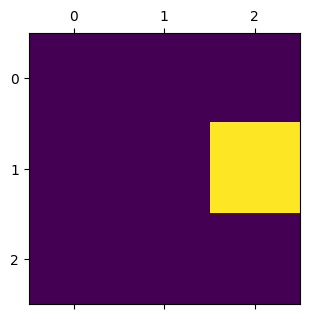

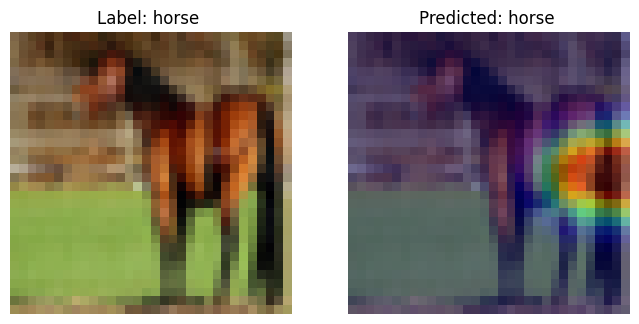

Forward hook running...
Backward hook running...
Heatmap:


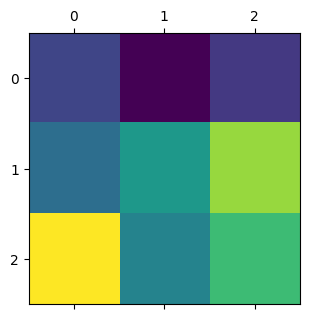

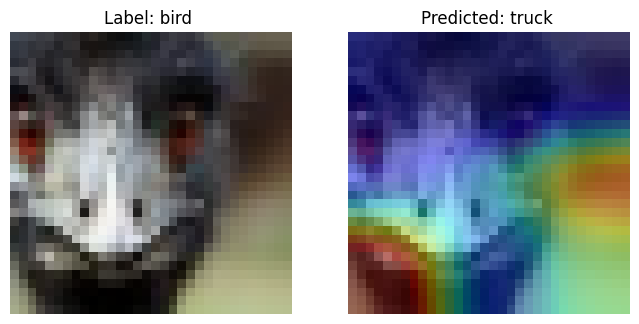

Forward hook running...
Backward hook running...
Heatmap:


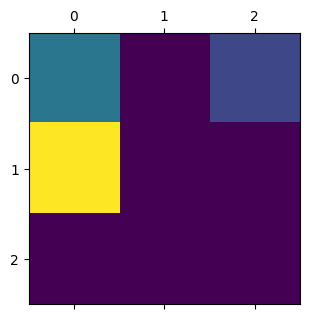

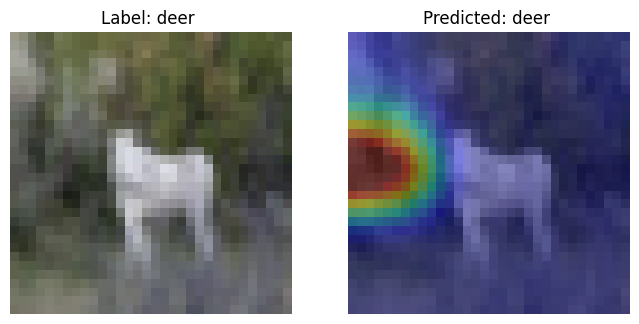

Forward hook running...
Backward hook running...
Heatmap:


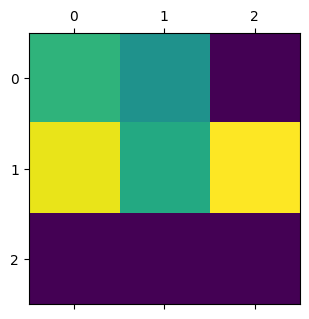

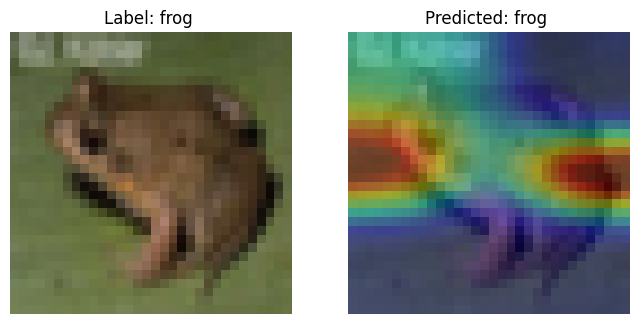

Forward hook running...
Backward hook running...
Heatmap:


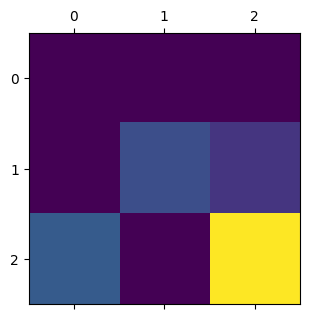

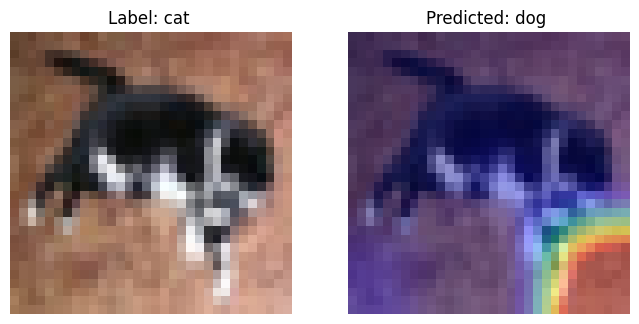

Forward hook running...
Backward hook running...
Heatmap:


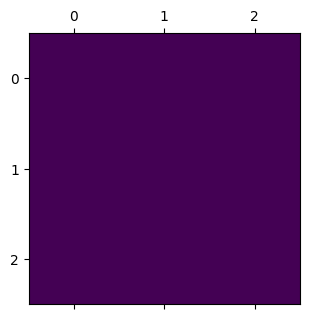

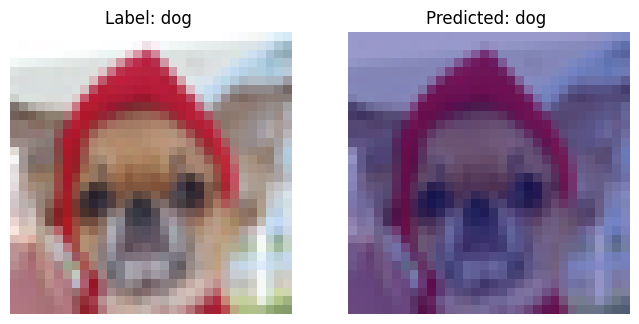

Forward hook running...
Backward hook running...
Heatmap:


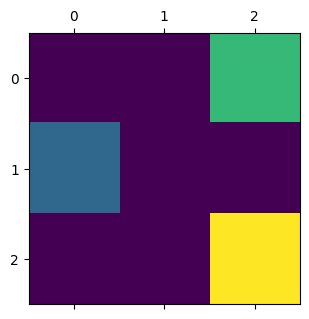

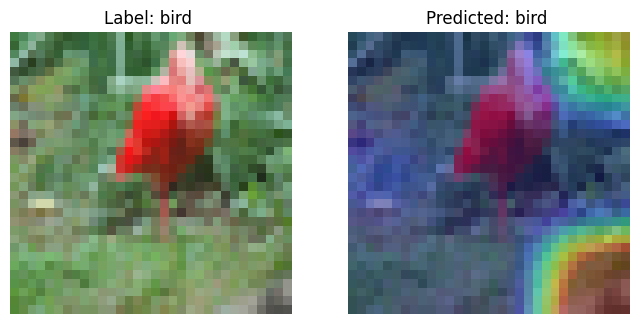

Forward hook running...
Backward hook running...
Heatmap:


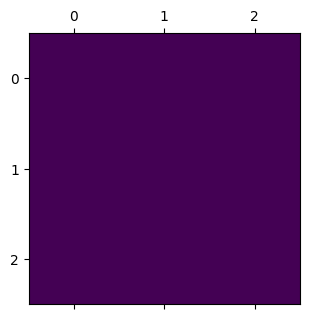

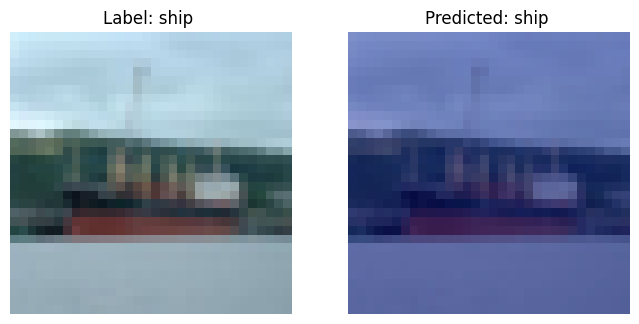

Forward hook running...
Backward hook running...
Heatmap:


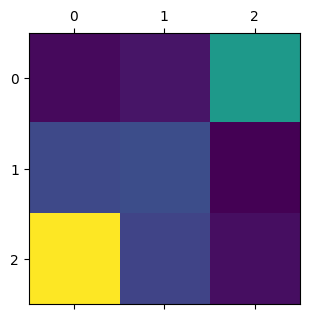

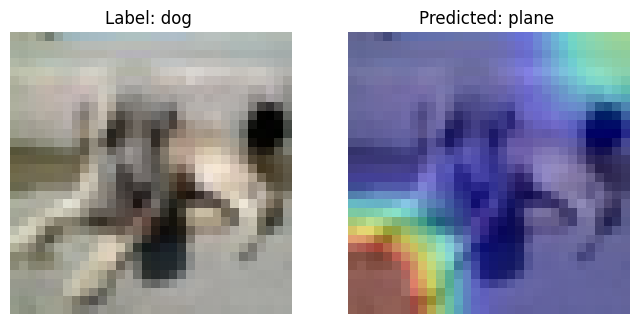

Forward hook running...
Backward hook running...
Heatmap:


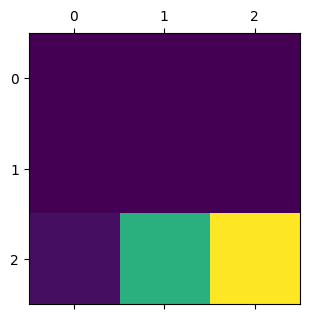

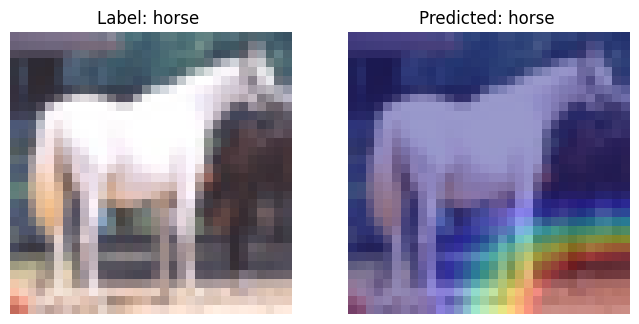

In [10]:
# Choosing a seed to get always the same images
torch.manual_seed(22)

for _ in range(10):
    gradCAM(model_cnn, dl_test_cifar)

In [11]:
backward_hook_CNN.remove()
forward_hook_CNN.remove()

##### Layer 2

In [12]:
# Register a backward hook on the module 
backward_hook_CNN_2 = model_cnn.layer2[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_CNN_2 = model_cnn.layer2[-1].register_forward_hook(forward_hook, prepend=False)

Forward hook running...
Backward hook running...
Heatmap:


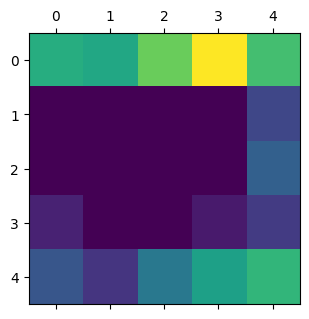

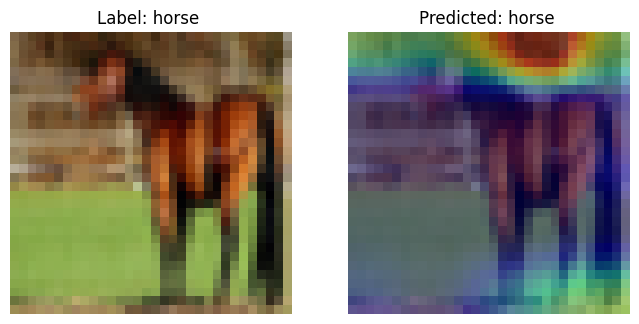

Forward hook running...
Backward hook running...
Heatmap:


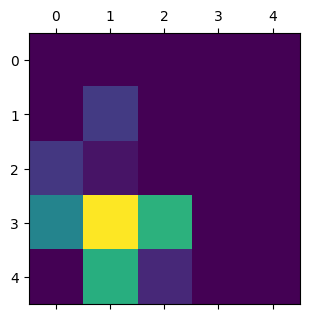

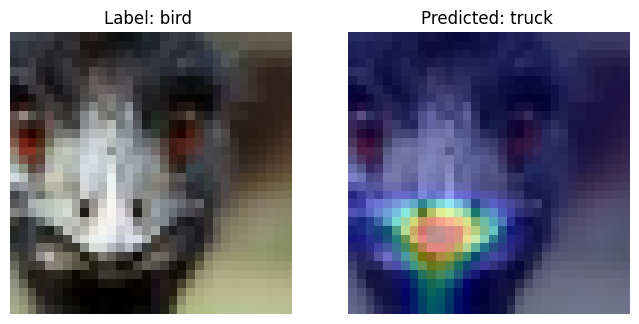

Forward hook running...
Backward hook running...
Heatmap:


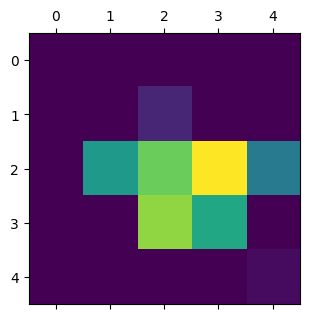

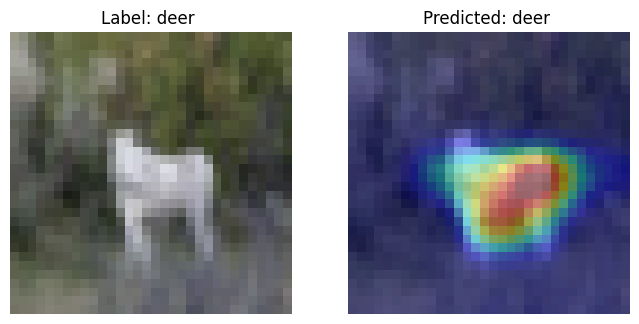

Forward hook running...
Backward hook running...
Heatmap:


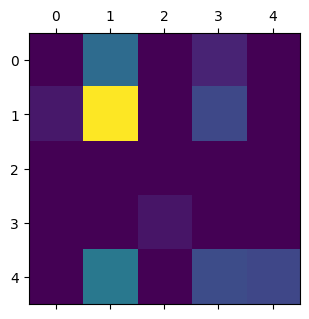

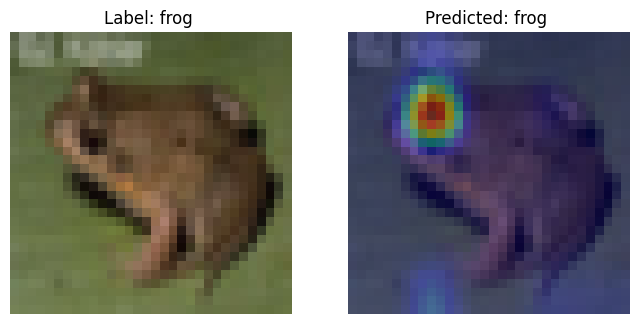

Forward hook running...
Backward hook running...
Heatmap:


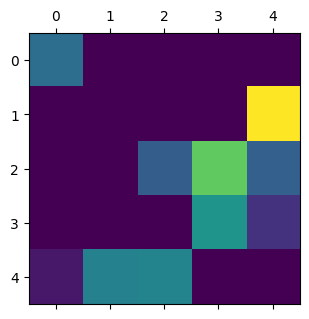

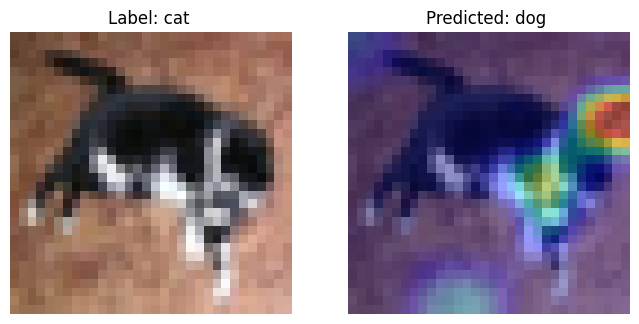

Forward hook running...
Backward hook running...
Heatmap:


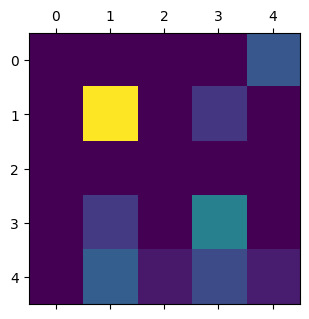

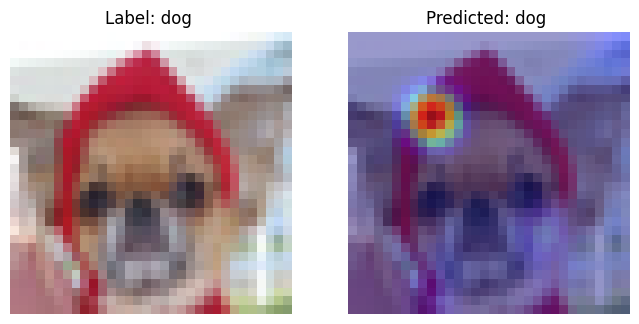

Forward hook running...
Backward hook running...
Heatmap:


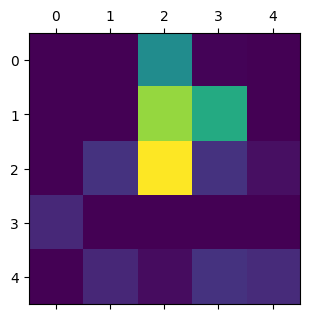

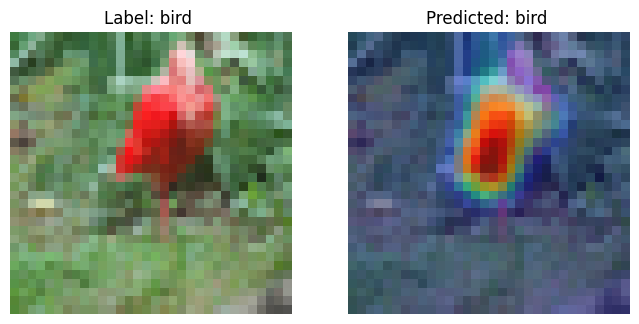

Forward hook running...
Backward hook running...
Heatmap:


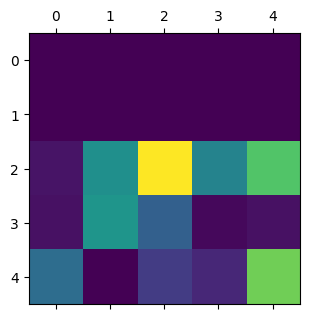

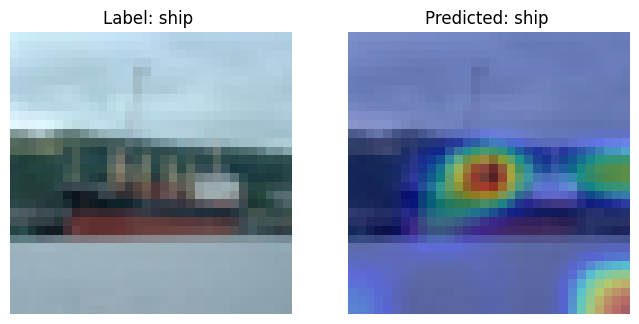

Forward hook running...
Backward hook running...
Heatmap:


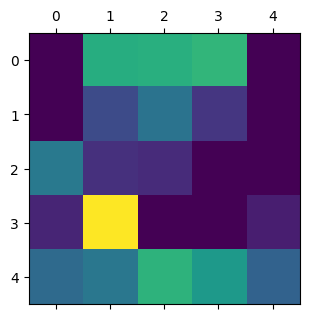

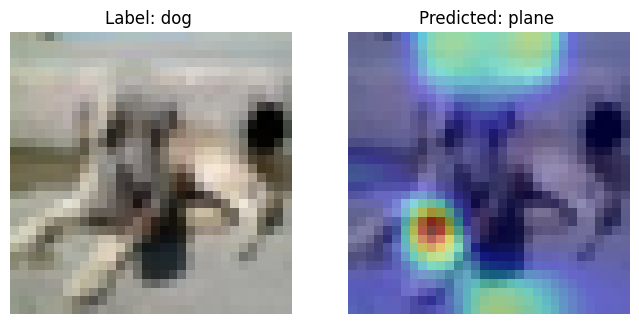

Forward hook running...
Backward hook running...
Heatmap:


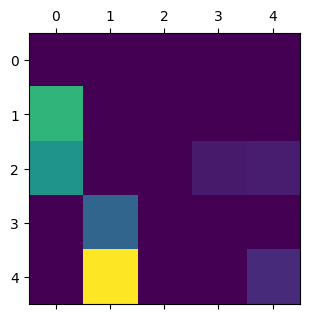

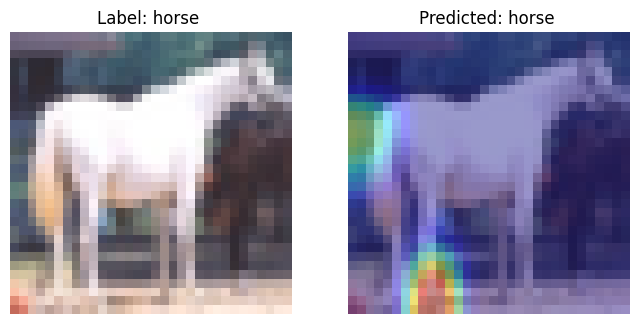

In [13]:
# Choosing a seed to get always the same images
torch.manual_seed(22)

for _ in range(10):
    gradCAM(model_cnn, dl_test_cifar)

In [14]:
backward_hook_CNN_2.remove()
forward_hook_CNN_2.remove()

##### Layer 1

In [15]:
# Register a backward hook on the module 
backward_hook_CNN_1 = model_cnn.layer1[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_CNN_1 = model_cnn.layer1[-1].register_forward_hook(forward_hook, prepend=False)

Forward hook running...
Backward hook running...
Heatmap:


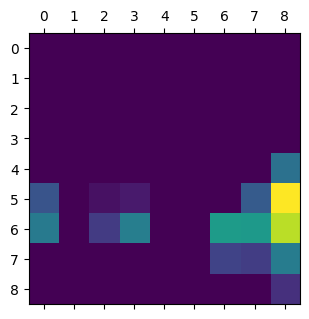

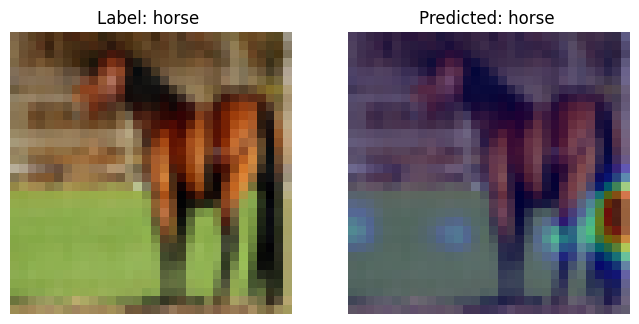

Forward hook running...
Backward hook running...
Heatmap:


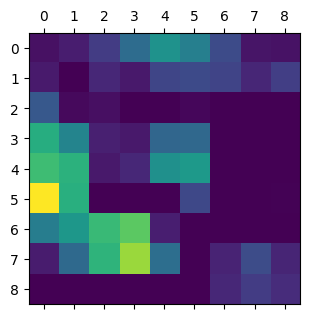

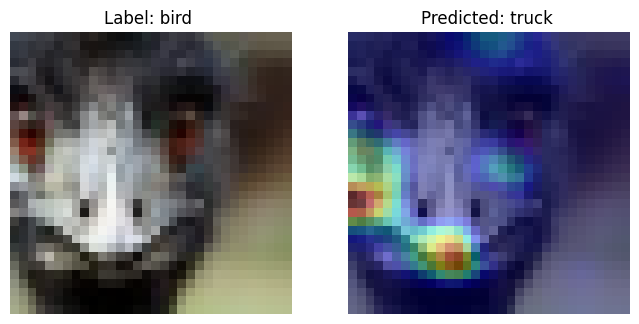

Forward hook running...
Backward hook running...
Heatmap:


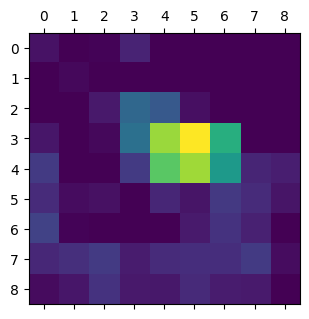

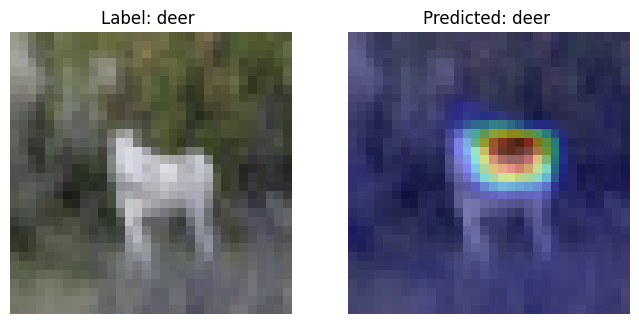

Forward hook running...
Backward hook running...
Heatmap:


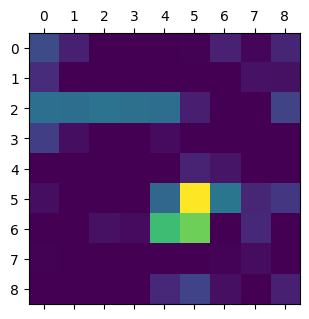

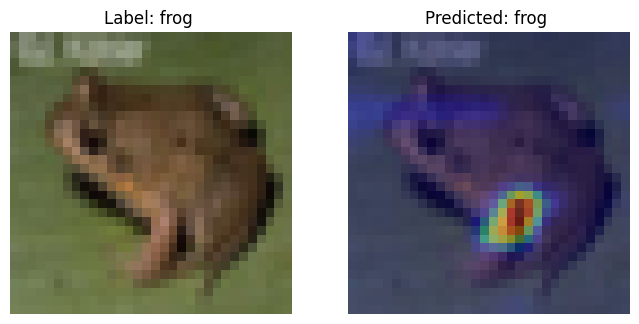

Forward hook running...
Backward hook running...
Heatmap:


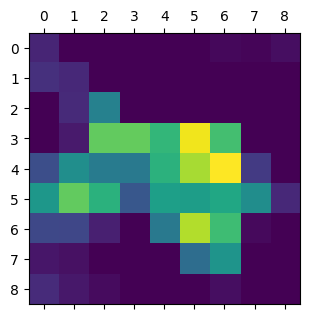

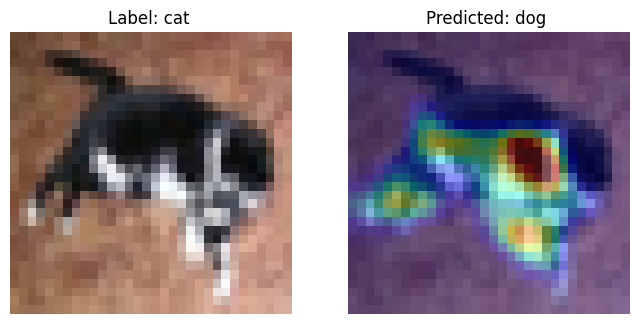

Forward hook running...
Backward hook running...
Heatmap:


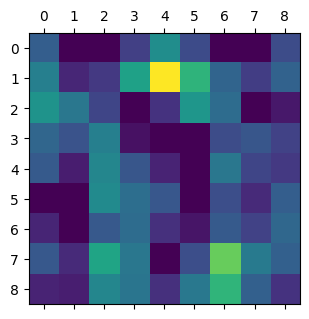

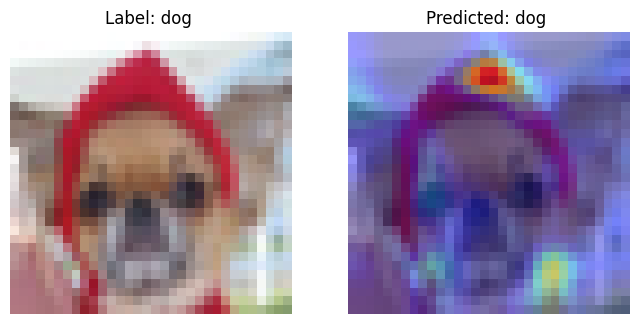

Forward hook running...
Backward hook running...
Heatmap:


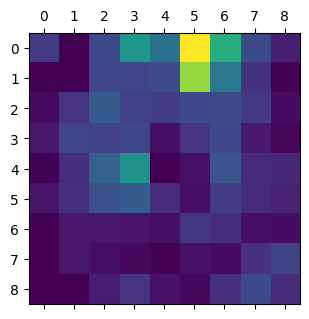

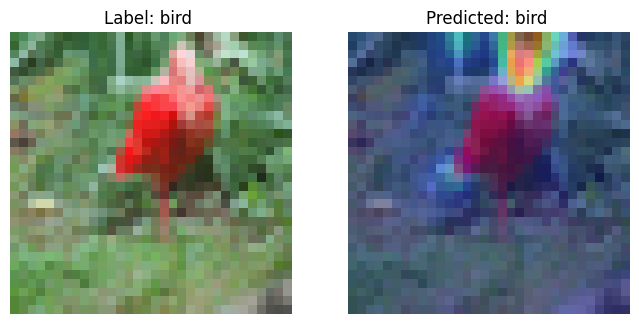

Forward hook running...
Backward hook running...
Heatmap:


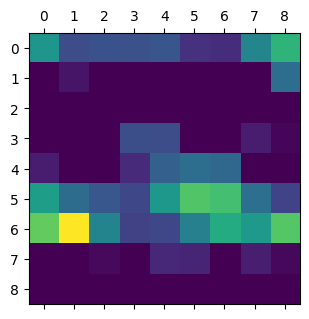

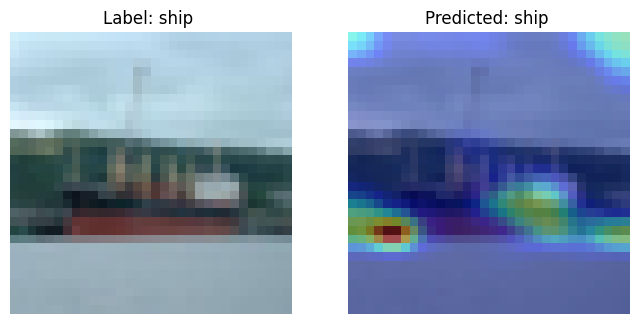

Forward hook running...
Backward hook running...
Heatmap:


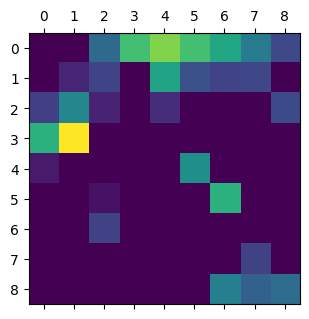

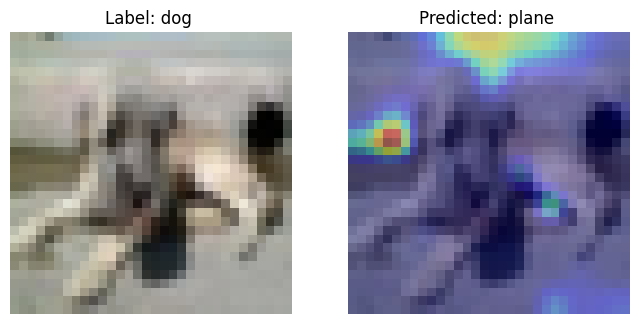

Forward hook running...
Backward hook running...
Heatmap:


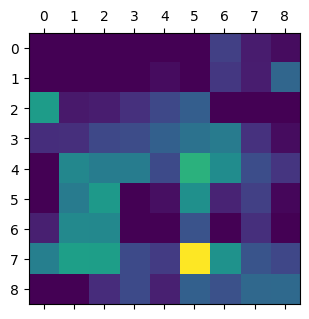

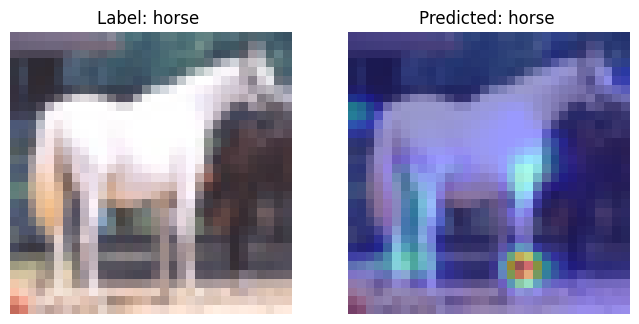

In [16]:
# Choosing a seed to get always the same images
torch.manual_seed(22)

for _ in range(10):
    gradCAM(model_cnn, dl_test_cifar)

In [17]:
backward_hook_CNN_1.remove()
forward_hook_CNN_1.remove()

#### CNN's examples
Images are shown starting with the first layer's results (the one closest to the input, layer1) to the last layer's results (the one closest to the output, layer3).

Since cifar10 images are small (32x32 pixels) the CNN's output after all the layers is also very small (3x3 pixels) resulting in a small heatmap (once again, 3x3) that does not seems able to be specific enough when indicating where the network was "looking at" to make a prediction, giving just a broad zone where the attention was.

This effect is mitigated when looking at previous layers that produce bigger heatmaps.

As it can be seen in the following examples, gradCAM identifies specific features of an image (i.e, the bird's head and body or the horse's hoofs and legs) that are able to explain the network's classification when it searches for saliency points with a bigger heatmap. When the heatmap is too little, after layer3, it just finds a broad region of possible interest that does not seem to be really anything important in the original image.

Lastly, gradCAM is able to give a possible hint to explain an incorrect prediction. The bird seems to have been misclassified as a truck because its beak could resemble the front of a large vehicle.

![CNN-gradCAM](Images/birdCNN1.png)
![CNN-gradCAM](Images/birdCNN2.png)
![CNN-gradCAM](Images/birdCNN3.png)

![CNN-gradCAM](Images/horseCNN1.png)
![CNN-gradCAM](Images/horseCNN2.png)
![CNN-gradCAM](Images/horseCNN3.png)

![CNN-gradCAM](Images/truckCNN1.png)
![CNN-gradCAM](Images/truckCNN2.png)
![CNN-gradCAM](Images/truckCNN3.png)

#### Pet

To better analyze Grad-CAM's behaviour I took a BitResNet152x2 I trained on OxfordPet 37 since it does have great performances (it achieve more than 90% test accuracy) on a dataset with images at a higher resolution (224x224 pixels).

In [11]:
import torchvision as tv

torch.manual_seed(1)

#Load Oxford Pet 37
transform_pet = tv.transforms.Compose([
      tv.transforms.Resize((224,224)),
      tv.transforms.ToTensor(),
    ])
pet37_test_set = tv.datasets.OxfordIIITPet(root='./data', split = 'test', transform = transform_pet, download=True)
# Dataloader
dl_test_pet = torch.utils.data.DataLoader(pet37_test_set, batch_size=1, shuffle=True)

# pet37 classes
classes = pet37_test_set.classes


#### BitResNet

In [ ]:
import bit_pytorch.models as models

device = 'cuda'

# Load trained model
BitResNet = models.KNOWN_MODELS['BiT-M-R152x2'](head_size=len(classes)).to(device)
BitResNet = torch.nn.DataParallel(BitResNet)
checkpoint = torch.load('/data01/dl24marchi/DLAProjects/pet/bit.pth.tar', map_location="cpu")
BitResNet.load_state_dict(checkpoint["model"])

# Transformations to test the Net
transform = tv.transforms.Compose([
      tv.transforms.Resize((224,224)),
      tv.transforms.ToTensor(),
      tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
# Load pet 37
pet37_test_acc = tv.datasets.OxfordIIITPet(root='./data', split = 'test', transform = transform, download=True)
# Dataloader
dl_test_pet_acc = torch.utils.data.DataLoader(pet37_test_acc, batch_size=128, shuffle=False)

test_accuracy = test_evaluation(BitResNet, dl_test_pet_acc, classes= classes, device = device)

# Remove data parallel
BitResNet = BitResNet.module.to(device)


![CNN](Images/BitResNet.png)

##### Block 4

In [27]:

# Register a backward hook on the module 
backward_hook_Bit = BitResNet.body.block4[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_Bit = BitResNet.body.block4[-1].register_forward_hook(forward_hook, prepend=False)
transform_norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

Forward hook running...
Backward hook running...
Heatmap:


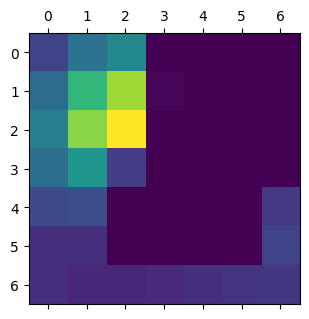

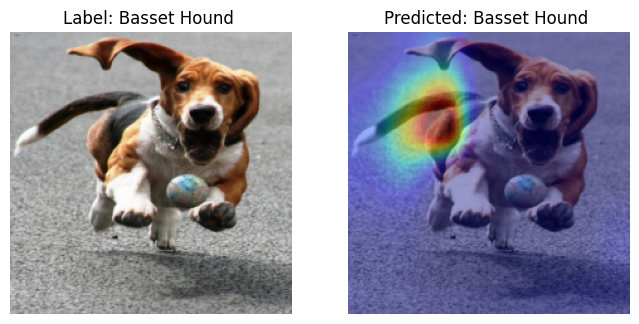

Forward hook running...
Backward hook running...
Heatmap:


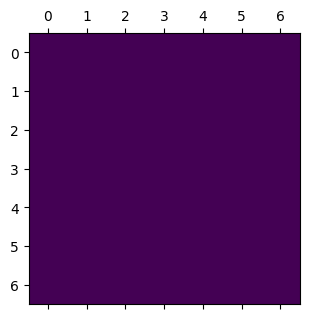

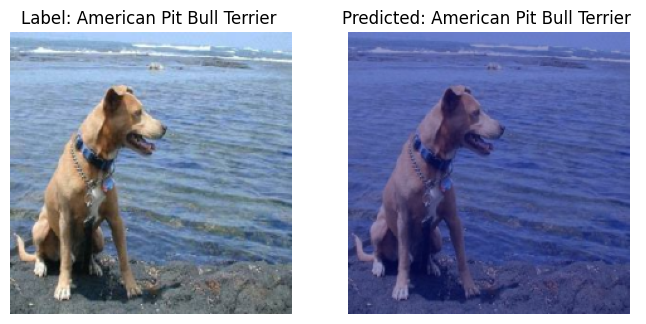

Forward hook running...
Backward hook running...
Heatmap:


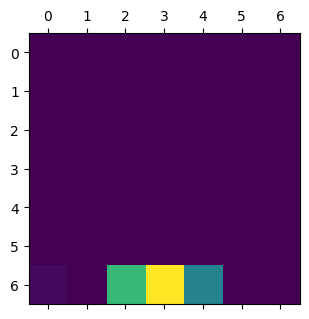

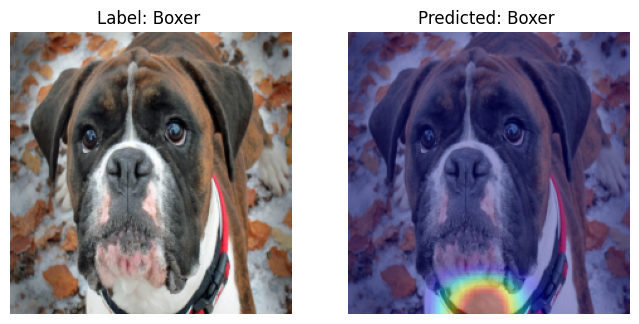

Forward hook running...
Backward hook running...
Heatmap:


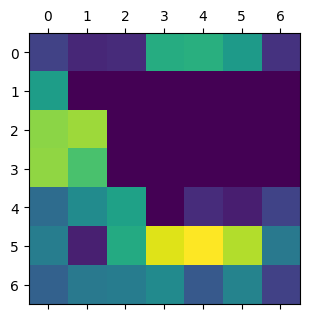

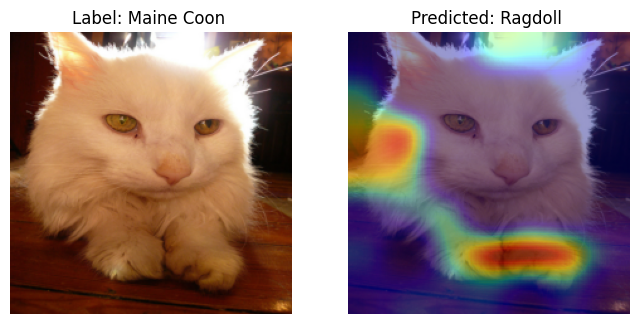

Forward hook running...
Backward hook running...
Heatmap:


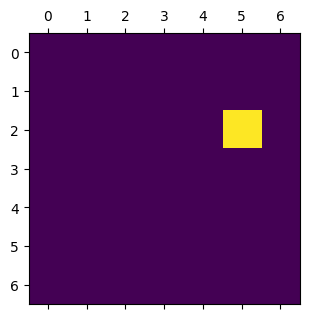

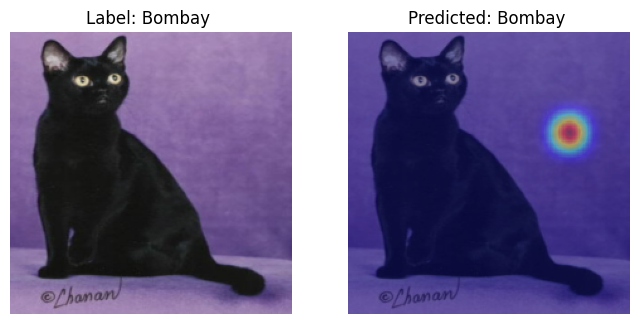

Forward hook running...
Backward hook running...


Heatmap:


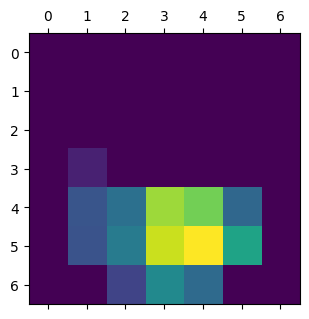

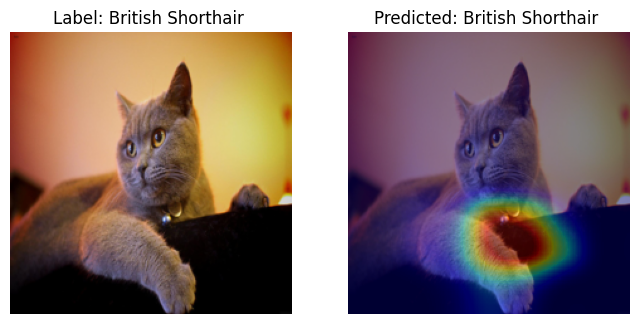

Forward hook running...
Backward hook running...
Heatmap:


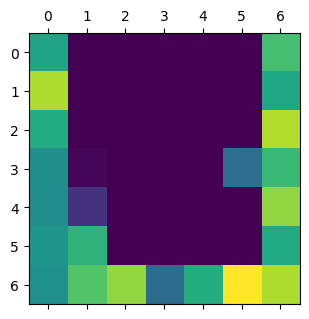

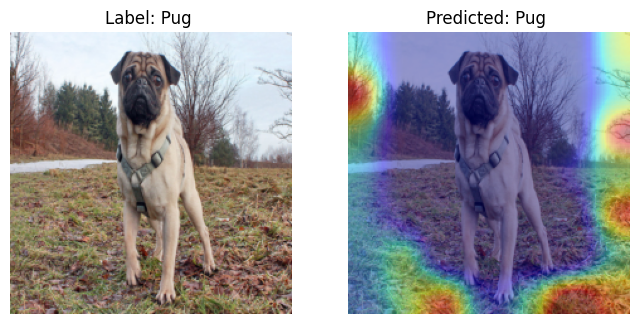

Forward hook running...
Backward hook running...
Heatmap:


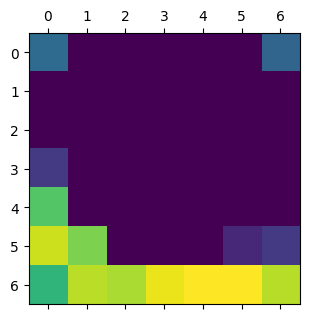

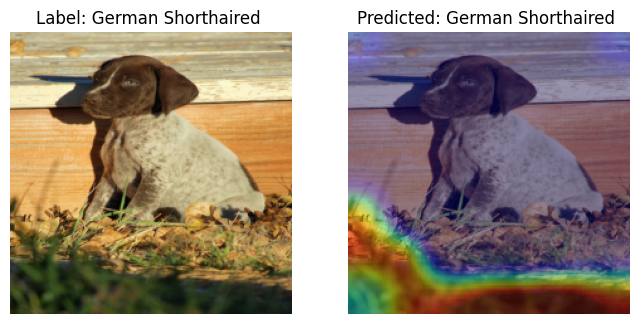

Forward hook running...
Backward hook running...
Heatmap:


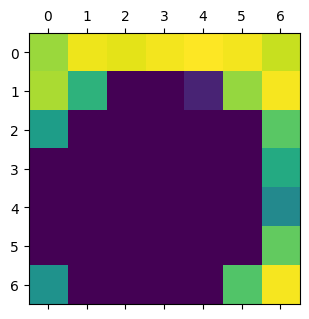

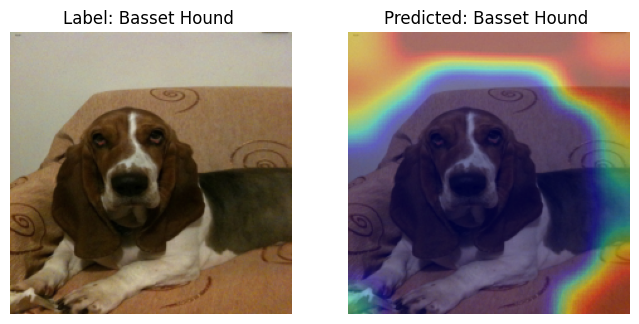

Forward hook running...
Backward hook running...
Heatmap:


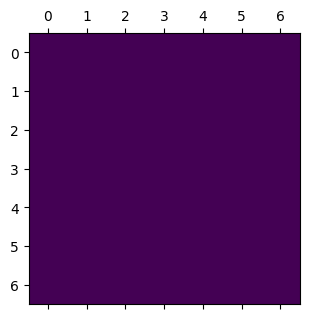

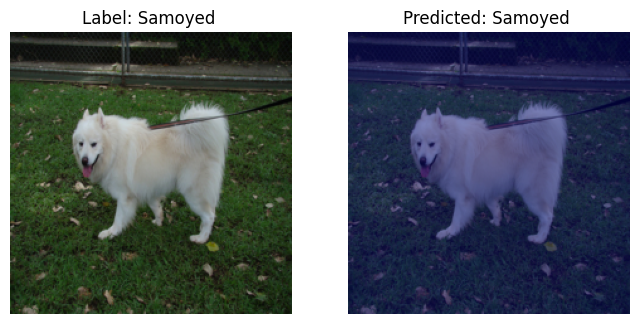

In [28]:
# Choosing a seed to get always the same images
torch.manual_seed(2)

for _ in range(10):
    gradCAM(BitResNet, dl_test_pet, image_size=224)

In [29]:
backward_hook_Bit.remove()
forward_hook_Bit.remove()

##### Block 3

In [35]:
# Register a backward hook on the module 
backward_hook_Bit_3= BitResNet.body.block3[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_Bit_3 = BitResNet.body.block3[-1].register_forward_hook(forward_hook, prepend=False)
transform_norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

Forward hook running...
Backward hook running...
Heatmap:


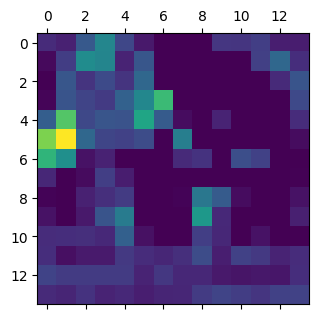

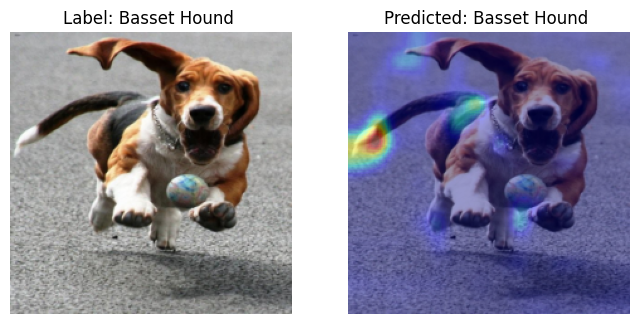

Forward hook running...
Backward hook running...
Heatmap:


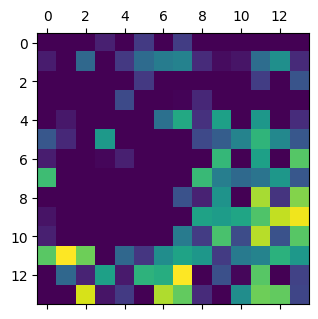

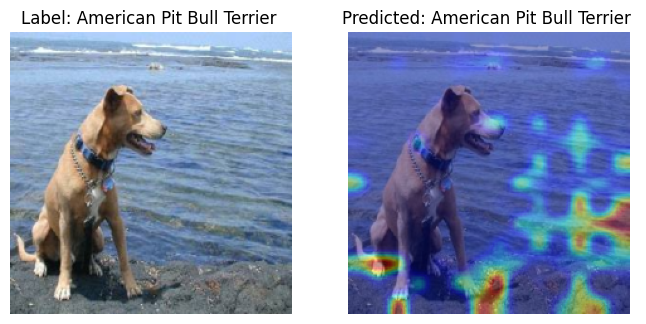

Forward hook running...
Backward hook running...
Heatmap:


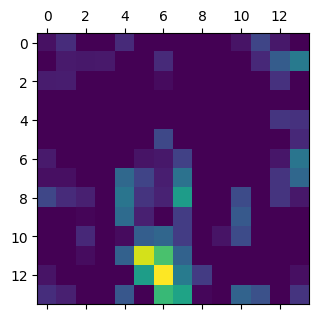

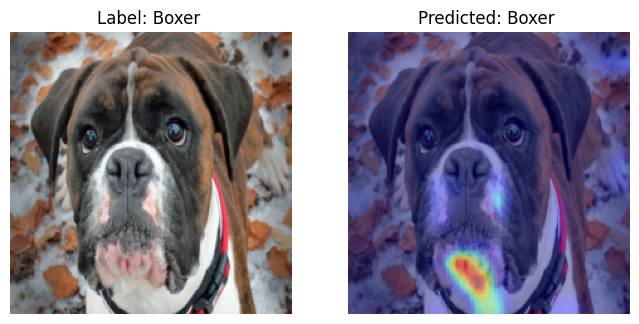

Forward hook running...
Backward hook running...
Heatmap:


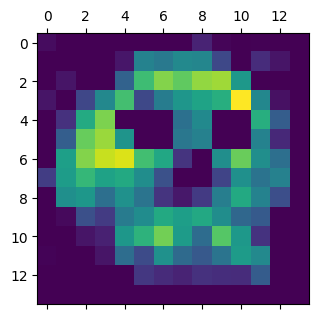

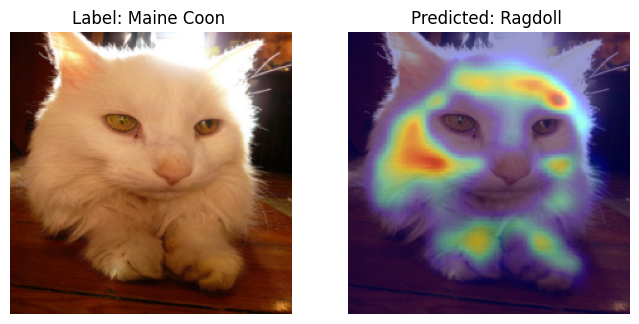

Forward hook running...
Backward hook running...
Heatmap:


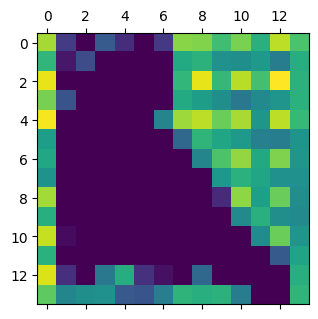

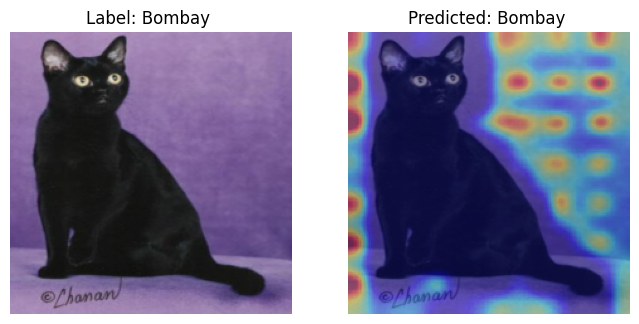

Forward hook running...
Backward hook running...
Heatmap:


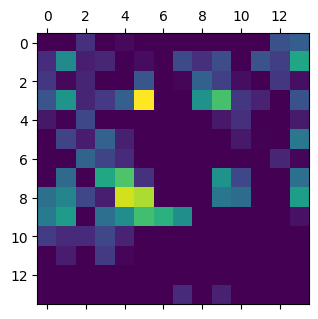

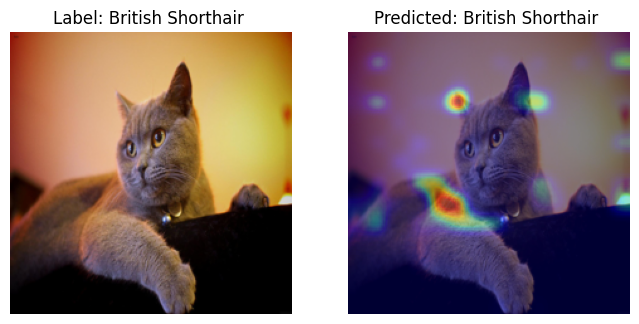

Forward hook running...
Backward hook running...
Heatmap:


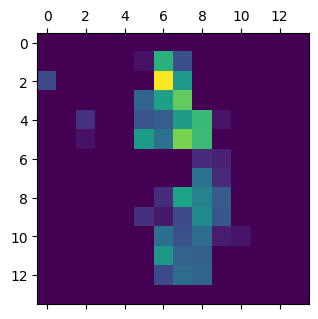

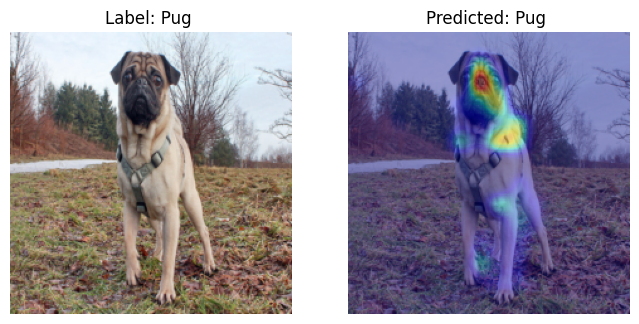

Forward hook running...
Backward hook running...
Heatmap:


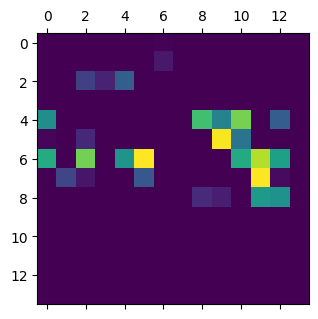

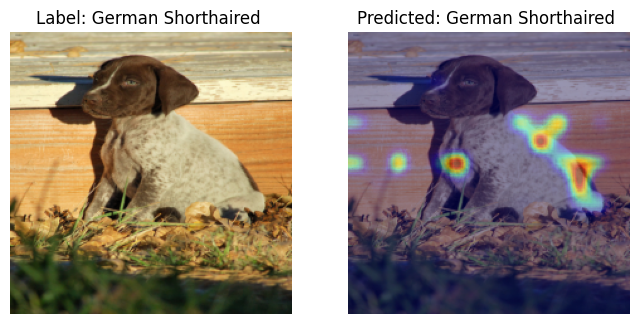

Forward hook running...
Backward hook running...
Heatmap:


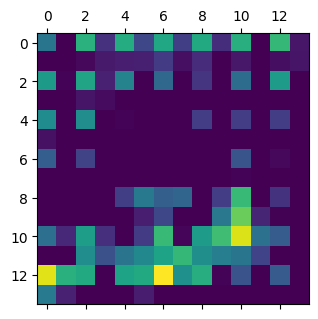

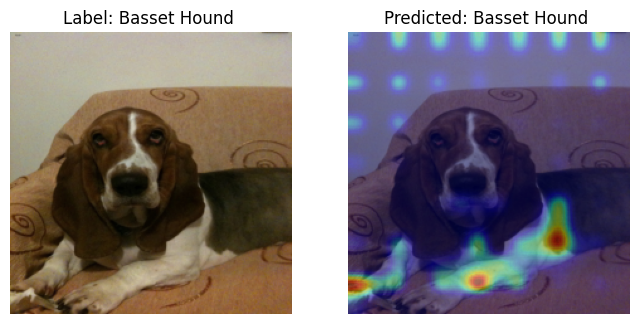

Forward hook running...
Backward hook running...
Heatmap:


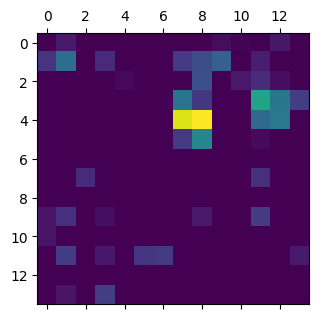

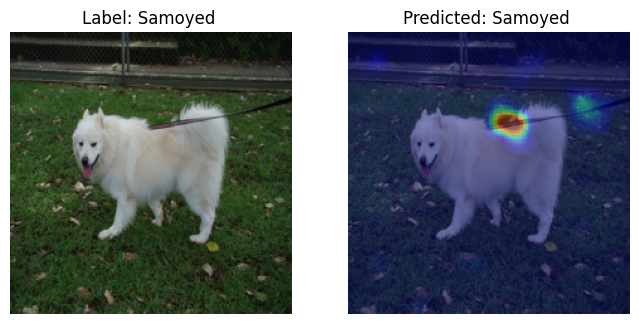

In [36]:
# Choosing a seed to get always the same images
torch.manual_seed(2)

for _ in range(10):
    gradients=None
    activations= None
    gradCAM(BitResNet, dl_test_pet, image_size=224)

In [37]:
backward_hook_Bit_3.remove()
forward_hook_Bit_3.remove()

#### BitResNet's examples
Images are shown starting with the first layer's results (the one closest to the input from the layers I choose, block 3) to the last layer's results (the one closest to the output, block 4).

Once again, it seems that using grad-CAM on the last layer does not produce the best results, the points it highlights seem a little too generic (i.e. some background for the pug, a point in the wall for the bombay). On the contrary, when looking at the saliency points found computing grad-CAM on block 3, we can clearly see features that seem reasonably used to identify which breed a dog or cat is (i.e. the pug's face). Interestingly enough the bombay seems to be classified correctly enough though the network is looking at the background, as if it was recognizing the shape of the cat (the background of the cat is "cat shaped").

It is also interesting to look at the last example, the maine coon predicted as a ragdoll. Although I am not an expert, it seems that the most significant difference between these two breeds is the ear's shape. Looking at the grad-CAM's results we could hypothesize that, looking only at the head's shape and paws, the model was not able to "see" the ears and wrongly classified the cat as a very similar breed.


![BitResNet-gradCAM](Images/BitPug3.png)
![BitResNet-gradCAM](Images/BitPug4.png)

![BitResNet-gradCAM](Images/Bitbomb3.png)
![BitResNet-gradCAM](Images/Bitbomb4.png)

![BitResNet-gradCAM](Images/Bitmain3.png)
![BitResNet-gradCAM](Images/Bitmain4.png)